Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

## House Prices Prediction
### Model training with Automated Machine Learning and Model Explainability

In this tutorial we will perform the same basic data preparation and model training steps as we did before, but know with the help of Azure ML service for Automated Machine Learning and Model Explainability.

We begin by importing the necessary packages and setting some notebook options.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, logging
import json

from azureml.core import Workspace
from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.train.automl import AutoMLConfig
from azureml.core.experiment import Experiment
from azureml.widgets import RunDetails

from azureml.explain.model._internal.explanation_client import ExplanationClient
#from azureml.train.automl.automl_explain_utilities import AutoMLExplainerSetupClass, automl_setup_model_explanations
from azureml.train.automl.runtime.automl_explain_utilities import AutoMLExplainerSetupClass, automl_setup_model_explanations
from azureml.explain.model.mimic.models.lightgbm_model import LGBMExplainableModel
from azureml.explain.model.mimic_wrapper import MimicWrapper
#from azureml.contrib.explain.model.visualize import ExplanationDashboard
from interpret_community.widget import ExplanationDashboard

warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

Here we are going to train locally. Therefore, instead of executing the data loading and preparation steps in a separate script, we just execute them here.

In [21]:
df_housing = pd.read_csv("./data/ames.csv")

df_housing.drop("Order", axis = 1, inplace = True)
df_housing.drop("PID", axis = 1, inplace = True)

fill_none = ["Pool.QC", "Misc.Feature", "Alley", "Fence", "Fireplace.Qu", "Garage.Type", "Garage.Finish", "Garage.Qual", "Garage.Cond",
            "Bsmt.Exposure", "Bsmt.Cond", "Bsmt.Qual", "Mas.Vnr.Type"]
for var in fill_none:
    df_housing[var] = df_housing[var].fillna("None")
    
fill_zero = ["Garage.Yr.Blt", "BsmtFin.Type.2", "BsmtFin.Type.1", "Bsmt.Half.Bath", "Bsmt.Full.Bath", "Total.Bsmt.SF",
             "Bsmt.Unf.SF", "BsmtFin.SF.1", "BsmtFin.SF.2", "Garage.Area", "Garage.Cars", "Mas.Vnr.Area"]
for var in fill_zero:
    df_housing[var] = df_housing[var].fillna(0)

df_housing["Lot.Frontage"] = df_housing.groupby("Neighborhood")["Lot.Frontage"].transform(lambda x: x.fillna(x.median()))

df_housing['Electrical'] = df_housing['Electrical'].fillna(df_housing['Electrical'].mode()[0])

df_housing = df_housing.dropna()

response_var = ["SalePrice"]

numeric_vars = ["Lot.Frontage", "Lot.Area", "Mas.Vnr.Area", "BsmtFin.SF.1", "BsmtFin.SF.2", "Bsmt.Unf.SF", "Total.Bsmt.SF",
                "X1st.Flr.SF", "X2nd.Flr.SF", "Low.Qual.Fin.SF", "Gr.Liv.Area", "Garage.Area", "Wood.Deck.SF",
                "Open.Porch.SF", "Enclosed.Porch", "X3Ssn.Porch", "Screen.Porch", "Pool.Area", "Misc.Val"]

categorical_vars = [v for v in df_housing.columns if v not in numeric_vars + response_var]

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature + '_E'] = o
    
categorical_vars_E = []
for q in categorical_vars:  
    encode(df_housing, q)
    df_housing[q + '_E'] = df_housing[q + '_E'].astype('int')
    categorical_vars_E.append(q + '_E')
    
X_train, X_test, y_train, y_test = train_test_split(df_housing[numeric_vars + categorical_vars_E], df_housing[response_var],
                                                    test_size = 0.4, random_state = 0)

Now we instantiate a [Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspaces) object, using the information from the configuration file that we uploaded previously.

In [22]:
config_file = open('config/ws_config.json')
cred_dict = json.load(config_file)

ws = Workspace.from_config(path = "./config/ws_config.json")

The first step before using [automated machine learning](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml) is to define the configuration for the AutoML job submission.

This is done by creating a [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.automlconfig?view=azure-ml-py) object.

There are several parameters in the [configuration](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train) that control the automated machine learning job execution, such as number of iterations, iteration timeout, primary model metric, and many others.

Here we are defining some of those parameters in a dictionary, to be later unpacked as arguments when creating the AutoMLConfig object.

In [52]:
automl_settings = {
    "iteration_timeout_minutes": 15,
    "iterations": 15,
    "primary_metric": "normalized_mean_absolute_error",
    "preprocess": True,
    "verbosity": logging.INFO,
    "n_cross_validations": 5,
    "model_explainability": True
}

In [53]:
automl_config = AutoMLConfig(task = "regression",
                             debug_log = "automated_ml_errors.log",
                             X = X_train,
                             y = y_train,
                             **automl_settings)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


Next, we instantiate an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiments) object and then submit our automated machine learning job for execution, passing the **AutoMLConfig** object created before.

In [54]:
experiment = Experiment(ws, "03_AML_Automated_ML")
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_a2c5e0eb-d29f-4019-8d8f-6512df3001c8

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************************************
Current status:

We can monitor the execution through a Jupyter [graphical widget](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-auto-train-models#explore-the-results), available through the RunDetails class.

In [63]:
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

After the job is completed, we can access the best run and best trained model.

By printing the best trained model, we can see the [steps](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#understand-automated-ml-models) that were automatically executed.

In [64]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: 03_AML_Automated_ML,
Id: AutoML_a2c5e0eb-d29f-4019-8d8f-6512df3001c8_13,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...7142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285]))]),
          stddev=None)


In [65]:
description = 'housing price model trained using AutoML'
tags = None
model = local_run.register_model(description = description, tags = tags, iteration = 3)
local_run.model_id # Use this id to deploy the model as a web service in Azur

'AutoMLa2c5e0ebd3'

We will refer to the model name returned above in our upcoming deployment notebook.

Here we compute model performance metrics for train and test datasets.

In [66]:
def MAPE(y_actual, y_predict):
    sum_actuals = sum_errors = 0
    
    for actual_val, predict_val in zip(y_actual, y_predict):
        abs_error = actual_val - predict_val
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    return sum_errors / sum_actuals

y_pred_train = fitted_model.predict(X_train)
y_pred_test = fitted_model.predict(X_test)
y_true_train = y_train.values.flatten()
y_true_test = y_test.values.flatten()

print("MAPE (Train): %f" % MAPE(y_true_train, y_pred_train))
print("MAPE (Test): %f" % MAPE(y_true_test, y_pred_test))

print("Acc (Train): %f" % (1 - MAPE(y_true_train, y_pred_train)))
print("Acc (Test): %f" % (1 - MAPE(y_true_test, y_pred_test)))

print("MAE (Train): %f" % mean_absolute_error(y_true_train, y_pred_train))
print("MAE (Test): %f" % mean_absolute_error(y_true_test, y_pred_test))

print("R2 (Train): %f" % r2_score(y_true_train, y_pred_train))
print("R2 (Test): %f" % r2_score(y_true_test, y_pred_test))

MAPE (Train): 0.051875
MAPE (Test): 0.075910
Acc (Train): 0.948125
Acc (Test): 0.924090
MAE (Train): 9393.188336
MAE (Test): 13682.797109
R2 (Train): 0.965626
R2 (Test): 0.893618


Now let's visualize the plots for predicted versus actual values for both train and test datasets.

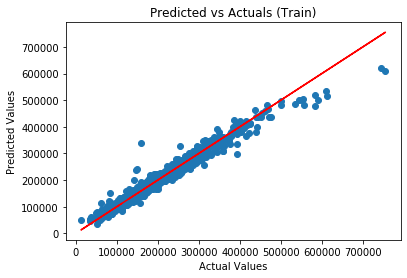

In [67]:
plt.scatter(y = y_pred_train, x = y_true_train)
plt.plot(y_true_train, y_true_train, color = "red")
plt.title("Predicted vs Actuals (Train)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

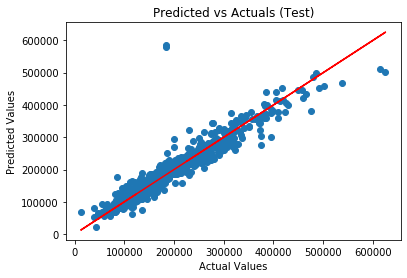

In [68]:
plt.scatter(y = y_pred_test, x = y_true_test)
plt.plot(y_true_test, y_true_test, color = "red")
plt.title("Predicted vs Actuals (Test)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Finally, let's plot the error distributions for both train and test datasets.

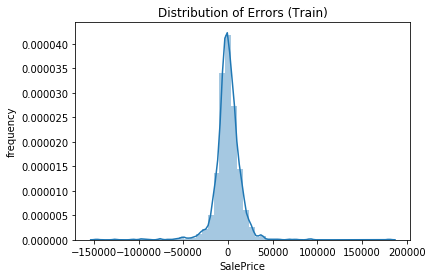

In [69]:
ax = sns.distplot(y_pred_train - y_true_train)
ax.set(title = "Distribution of Errors (Train)", xlabel = "SalePrice", ylabel = "frequency")
plt.show()

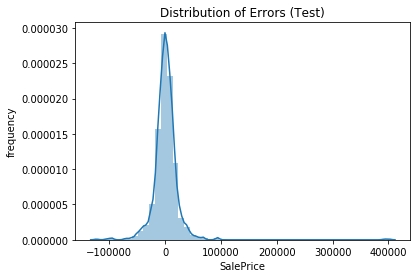

In [70]:
ax = sns.distplot(y_pred_test - y_true_test)
ax.set(title = "Distribution of Errors (Test)", xlabel = "SalePrice", ylabel = "frequency")
plt.show()

As a final step, we are going to show how to use some of the [model interpretability](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability) features available on AML service.

Please notice that these are experimental features, and the supported functionality and API interfaces are still evolving.

Here we instantiate a **ExplanationClient** object, passing the best run from the job execution, to get variable feature importance scores for the engineered features (after the transformations performed automatically).

In [71]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw = False)
feature_importance_dict = engineered_explanations.get_feature_importance_dict()
{k:v for k,v in feature_importance_dict.items() if v > 0}

{'Gr.Liv.Area_MeanImputer': 14650.14747601538,
 'Garage.Cars_E_CharGramCountVectorizer_6': 11382.943263147488,
 'Year.Built_E_MeanImputer': 8734.88909576234,
 'Total.Bsmt.SF_MeanImputer': 7056.449678361944,
 'Bsmt.Qual_E_CharGramCountVectorizer_6': 6206.234418204015,
 'Fireplaces_E_CharGramCountVectorizer_1': 4325.02353960381,
 'Kitchen.Qual_E_CharGramCountVectorizer_5': 4197.5234391403255,
 'BsmtFin.SF.1_MeanImputer': 3452.882416863508,
 'Year.Remod.Add_E_MeanImputer': 3440.4197631459624,
 'X1st.Flr.SF_MeanImputer': 3384.979641300417,
 'Kitchen.Qual_E_CharGramCountVectorizer_3': 2958.338183438446,
 'Exter.Qual_E_CharGramCountVectorizer_3': 2891.448188545328,
 'Garage.Area_MeanImputer': 1975.5443317536838,
 'X2nd.Flr.SF_MeanImputer': 1892.4683154947204,
 'Lot.Area_MeanImputer': 1879.42322142754,
 'Garage.Cars_E_CharGramCountVectorizer_4': 1871.992517547901,
 'BsmtFin.Type.1_E_CharGramCountVectorizer_7': 1686.8290820704049,
 'Kitchen.Qual_E_CharGramCountVectorizer_4': 1397.8710289489934

As we can see, for a categorical feature, an importance score is generated for each category. If we want to score the overall feature, we can get the raw explanation.

In [72]:
client = ExplanationClient.from_run(best_run)
raw_explanations = client.download_model_explanation(raw=True)
raw_explanations.get_feature_importance_dict()

UserErrorException: UserErrorException:
	Message: Did not find any explanations matching comment or raw filters.
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Did not find any explanations matching comment or raw filters."
    }
}

With that feature importance scores, we can then [visualize](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#visualizations) and interact with them to evaluate the effects of the variables on the predictions.

In [ ]:
ExplanationDashboard(raw_explanations, fitted_model, X_train)

We can also do the same for a specific run. AML service supports model interpretability and explainability in [several ways](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#how-to-interpret-your-model). Here we use a direct **Mimic Explainer** with a **LightGBM** as a surrogate model.

In [ ]:
automl_run, fitted_model = local_run.get_output(iteration = 0)

In [ ]:
automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X = X_train, 
                                                             X_test = X_test, y = y_train,
                                                             features = numeric_vars + categorical_vars_E,
                                                             task = "regression")

In [ ]:
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator, LGBMExplainableModel, 
                         init_dataset = automl_explainer_setup_obj.X_transform, run = automl_run,
                         features = automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps = [automl_explainer_setup_obj.feature_map],
                         classes = automl_explainer_setup_obj.classes)

In [ ]:
engineered_explanations = explainer.explain(['local', 'global'], eval_dataset = automl_explainer_setup_obj.X_test_transform)
engineered_feature_importance = engineered_explanations.get_feature_importance_dict()
{k:v for k, v in engineered_feature_importance.items() if v > 0}

In [ ]:
ExplanationDashboard(engineered_explanations, automl_explainer_setup_obj.automl_estimator, automl_explainer_setup_obj.X_test_transform)

In [ ]:
raw_explanations = explainer.explain(['local', 'global'], get_raw = True, 
                                     raw_feature_names = automl_explainer_setup_obj.raw_feature_names,
                                     eval_dataset = automl_explainer_setup_obj.X_test_transform)
raw_explanations.get_feature_importance_dict()

In [ ]:
ExplanationDashboard(raw_explanations, automl_explainer_setup_obj.automl_pipeline, automl_explainer_setup_obj.X_test_raw)